In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

<b>Assignment 5:</b> Apply canny edge detection algorithm to detect the edges of an image.
Compare your results with inbuilt canny edge detection function and the results of
assignment 4.

<h1> Canny Edge Detection Algrithm </h1>

In [2]:
#utility functions

#padding
def pad(img, size) :
    #create empty array of zeros
    emp = np.zeros((img.shape[0] + 2 * (size // 2), img.shape[1] + 2 * (size // 2)), dtype = np.uint8)
    for i in range(size // 2, img.shape[0] + size // 2 - 1) :
        for j in range(size // 2, img.shape[1] + size // 2 - 1) :
            #assign image pixels
            emp[i][j] = img[i - size][j - size]
    return emp

def conv(img, f) :
    f_size = f.shape[0]
    #first pad image
    pad_img = pad(img, f_size)
    #image to hold result of convolution
    res_img = np.zeros((img.shape[0],img.shape[1]),dtype = np.uint8)
    for i in range(img.shape[0]) :
        for j in range(img.shape[1]) :
            #part of image to undergo convolution
            ins_img = pad_img[i : i + f_size , j : j + f_size]
            val = int(np.sum(ins_img * f))
            #assignment of result of convolution as final image pixel
            res_img[i][j] = val
    return res_img

In [3]:
img = Image.open("DIP3E_Original_Images_CH02/Fig0222(a)(face).tif")
ar = np.asarray(img)

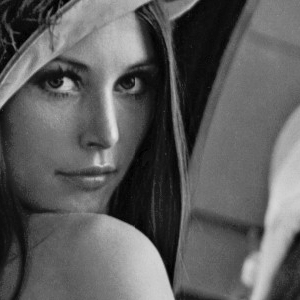

In [4]:
img

<h4> Step 1 : Smoothing by Gaussian filter </h4> 

In [5]:
import math
def create_gaussian_filter(sigma) :
    size = math.ceil(6 * sigma)
    mid = size // 2
    fil = np.zeros((size, size))
    s = 0
    for i in range(size) : 
        for j in range(size) :
            x = i - mid
            y = j - mid
            fil[i][j] = (x ** 2 + y ** 2) / (2 * (sigma ** 2))
            s += fil[i][j]
    fil = (1 / s) * fil
    return fil
    
def apply_gaussian(image, sigma = 7) :
    fil = create_gaussian_filter(sigma)
    res_img = conv(image, fil)
    return res_img

In [6]:
# insert in algo
gaussian_result_img = apply_gaussian(ar,1)

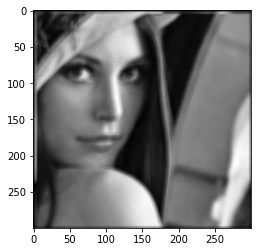

In [7]:
plt.imshow(gaussian_result_img, cmap = "gray")

<h4> Step 2 : Gradient Magnitude and Direction </h4>

In [8]:
#Using Sobel's filters for horizontal and vertical edge detection
mask_h = np.array([[-1, -2, -1],
         [0, 0, 0],
         [1, 2, 1]])
mask_v = np.array([[-1, 0, 1],
         [-2, 0, 2],
         [-1, 0, 1]])
def grads_x_y(subimg, mask_h, mask_v) :
    gx = np.sum(subimg * mask_h)
    gy = np.sum(subimg * mask_v)
    magnitude = math.sqrt(gx ** 2 + gy ** 2)
    if gy == 0 :
        direction = 0
    else :
        direction = math.atan(gx / gy)
    return gx, gy, magnitude, direction

In [9]:
gx, gy, mag, dirn = grads_x_y(ar[0:3, 0:3], mask_h, mask_v)
print(gx, gy, mag, dirn)

100 80 128.06248474865697 0.8960553845713439


<h4> Step 3 : Nonmaxima Supression </h4>

In [10]:
def nonmax_supression(subimage, gx, gy, magnitude, direction) :
    
    #finding nearest direction of gradient
    std_grads = np.array([math.atan(-1), math.atan(1), math.pi / 2, 0]) #[-45, 45, 90, 0]
    grad_diff = abs(std_grads - direction)
    dir_ind = np.argmin(grad_diff)
    
    #nonmax supression
    count = 0
    for i in range(subimage.shape[0]) :
        x = 0
        y = 0
        if dir_ind == 1 :
            x = i
            y = i
        elif dir_ind == 2 :
            x = i
            y = subimage.shape[0] - i -1
        elif dir_ind == 4 :
            x = subimage.shape[0] // 2
            y = i
        else :
            x = i
            y = subimage.shape[0] // 2
        if magnitude < subimage[x][y] :
            count += 1
            
    if count >= 2 :
        return 0
    return magnitude

In [11]:
g_nxy = nonmax_supression(ar[0:3, 0:3], gx, gy, mag, dirn)

In [12]:
def apply_non_max(image, mask_h, mask_v) :
    #resultant image container : g_n_xy
    res = np.zeros((image.shape[0], image.shape[1]))
    offset = mask_h.shape[0]
    for i in range(image.shape[0] - offset) :
        for j in range(image.shape[1] - offset) :
            subimage = image[i : i + offset, j : j + offset]
            gx, gy, mag, dirn = grads_x_y(subimage, mask_h, mask_v)
            res[i][j] = nonmax_supression(subimage, gx, gy, mag, dirn)
    return res

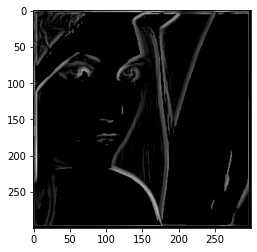

In [13]:
#insert in algo
step = apply_non_max(gaussian_result_img, mask_h, mask_v)
plt.imshow(step, cmap = "gray")

<h4> Step 4 : Hysteresis Thresholding </h4>

In [14]:
def threshold(image, th, tl) :
    gnh = (image > th) * image
    gnl = (image > tl) * image
    gnl -= gnh
    return gnh, gnl

In [15]:
tl = 50
th = 150
gnh, gnl = threshold(step, 50, 150)

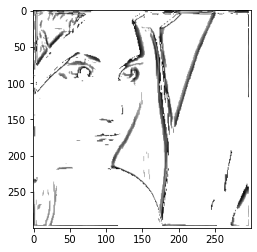

In [16]:
plt.imshow(gnl, cmap = "gray")

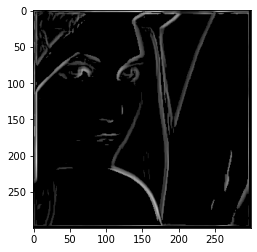

In [17]:
plt.imshow(gnh, cmap = "gray")

<h4> Step 5 : Edge Linking </h4>

In [18]:
def link_edges(gnh, gnl, th) :
    for i in range(gnh.shape[0]) :
        for j in range(gnl.shape[1]) :
            if i == 0 or j == 0 :
                pass 
            if gnh[i][j] != 0 :
                for x in range(i - 1, i + 2) :
                    for y in range(j - 1, j + 2) :
                        if x != i and y != j :
                            gnl[x][y] = gnh[i][j]
    gnl = (gnl > th) * gnl
    return gnh + gnl

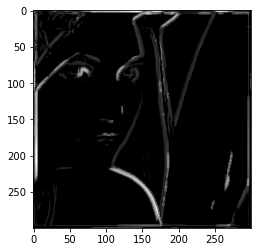

In [19]:
link_img = link_edges(gnh, gnl, th)
plt.imshow(link_img, cmap = "gray")

<h4> The Algorithm </h4>

In [20]:
def canny_edge_detection(img, th, tl, mask_h, mask_v, sigma) :
    ar = np.asarray(img)
    #Step 1 : apply gaussian filter
    gaussian_result_img = apply_gaussian(ar, sigma)
    #Step 2-3 : Gradient Magnitude and Direction and Nonmaxima supression
    nm_img = apply_non_max(gaussian_result_img, mask_h, mask_v)
    #Step 4 : Hysteresis Thresholding
    gnh, gnl = threshold(nm_img, th, tl)
    #Step 5 : Edge Linking
    linked_img = link_edges(gnh, gnl, th)
    
    return linked_img

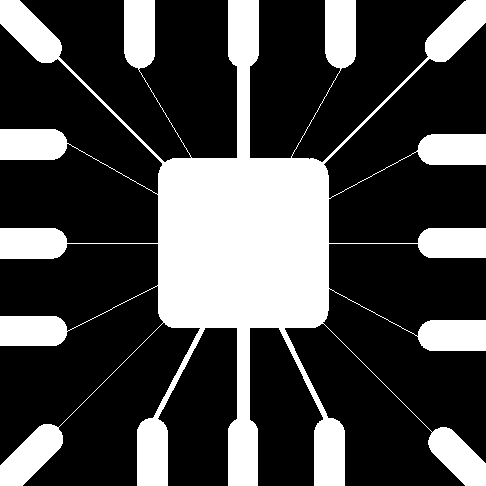

In [21]:
test_image = Image.open("DIP3E_Original_Images_CH10/Fig1005(a)(wirebond_mask).tif")
test_image

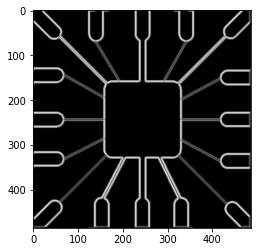

In [22]:
canny_test_image = canny_edge_detection(test_image, 100, 40, mask_h, mask_v, 0.5)
plt.imshow(canny_test_image,cmap = "gray")

<h6> Sobel's Edge Detection Results </h6>

<img src = "sobel horizontal.png" />
<p> Sobel's horizontal Edge detection results</p>

<img src = "sobel vertical.png" />
<p> Sobel's Vertical Edge detection results</p>

<h6> Robert's Edge Detection Results </h6>

<img src = "robert right diag.png" />
<p> Robert's left Diagonal Edge detection results</p>

<img src = "sobel left diag.png" />
<p> Robert's Right Diagonal Edge detection results</p>

<h6> Laplacian Edge Detection Results </h6>

<img src = "laplacian.png">

<h3> Analysis </h3>

The Canny edge detection algorithm performs better than most other edge detection algorithms. Other algorithms generally favour one direction over the other resulting in poor performance. However, Canny Edge detection algorithm takes into consideration all the principle directions and hence, produces the best results. 